## Final Project: House Prices Prediction
https://www.kaggle.com/c/house-prices-advanced-regression-techniques  

### Team MLAIRE: Chi Iong Ansjory, Prabhat Tripathi, Soodong Kim, Tina Agarwal

## Problem

The goal of this project is to predict sale price of residential homes in Ames, Iowa based on the given training and test data sets. There are 79 explanatory variables describing different aspects of residential homes with 1460 observations in both training and test data sets (this is different than previous class projects where train data is usually larger than test data set). 

The output variable (SalePrice) is quantitative (continuous) whereas the explanatory (LHS) variables are a combination of quantitative (continuous) and categorical variables. 

Considering the size and nature of the data set, and informed by our domain understanding, we believe that *feature engineering* -- crafting data features optimized for machine learning -- is key for better modeling for this problem. Specifically, we plan to perform following:

- Univariate analysis of output and explanatory variables: weed out spurious or wrong values. Understand patterns and outliers for each variable. Allow for missing values (NaN) imputations.
- Transform categorical variables into numeric (using dummy variables?)
- Check if log transformation of output and explanatory variables helps better model performance
- Through bivariate analysis, identify and remove unhelpful explanatory variables (using correlation matrix or using techniques such as LASSO) and multicollinearity (if present)
- Advance feature engineering techniques such as PCA?

We also have to watch out for overfitting considering there are a large number of input variables (compared to the training data size).

We plan to begin with (multiple) LinearRegression model (for speed) and if the accuracy is not satisfactory, we would try other models such as random forest and gradient-boosting tree. If needed, we may have to ensemble all these models for better overall accuracy. We will split test data into two random sets and use one as "dev" data during model building process.

## Import Libraries

Import necessary libraries such as sklearn, scipy, pandas, numpy, and seaborn.

In [19]:
# Each plot will not open a new window. 
# required libraries
## pandas
## seaborn
## XGBoost -- allows for correlated features
%matplotlib inline

# Import relevant libraries.

# General libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# SK-learn libraries for Projection/learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.grid_search import GridSearchCV
from sklearn import metrics
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

# Sk-Learn libraries for data mangling.
from sklearn import preprocessing

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

from scipy.stats import norm
from scipy import stats

# Libraries for files
import os

# Python fundamental libraries
import collections

# Disable warnings for more clear output
import warnings 
warnings.filterwarnings('ignore')

## Data Loading

### Import Data

Import both train and test data from csv files, make copies of both, and display the origin shapes of them.

In [2]:
# Load Data
from sklearn.cross_validation import train_test_split

# Please keep this relative path access to data.
dir_name = os.getcwd()
train_filename = os.path.join(dir_name, 'data/train.csv')
test_filename = os.path.join(dir_name, 'data/test.csv')

# Reading the data
train = pd.read_csv(train_filename)
test  = pd.read_csv(test_filename)

print("Original shapes of train and test datasets:")
train.shape, test.shape

Original shapes of train and test datasets:


((1460, 81), (1459, 80))

## Exploratory Data Analysis

### Features Summary

In this section, we summarize the train dataset features:  
* Categorize 80 features into numerical, categorical. Among numerical features, distinguish "discrete" values features
* Print a summary of numerical features with info such as: mean, min, max, number of NaNs, isDiscrete
* Print a summary of categorical features with info such as: number of NaNs, number of distinct values
* Print a summary on whether the features are selected or not based on following analysis

Descriptions of variables are based on https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data. Variable types are either categorical, or discrete/non-discrete numeric. There are 4 different "Segments": Sale (sales transaction of house), Location (where the house located), Building (physical characteristics), Space (space properties of house). For numerical variables, mean, min, max, and number of NaNs are derived from descriptive statistics, and also determine if it is discrete from the histogram. For categorical variables, number of NaNs and distinct values are determined by histogram. There are 3 levels of "Expectations": High, Medium, and Low of how the variables are related to the sale price. Column "Selected" indicates if the variables are included in the model based on the following analysis.

| ID | Variable | Description | Segment | Type | Discrete | Mean | Min | Max | NaN | Distinct Value | Expectation | Selected |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 1 | SalePrice | Property's sale price in dollars | Building | Numeric | No | 180921 | 34900 | 755000 | 0 | | Explantory Variable | Yes |
| 2 | MSSubClass | Building class | Building | Categorical | | | | | 0 | 15 | Low | No |
| 3 | MSZoning | General zoning classification | Building | Categorical | | | | | 0 | 5  | Low | No |
| 4 | LotFrontage | Linear feet of street connected to property | Space | Numeric | No | 70 | 21 | 313 | 259 | | Medium | No |
| 5 | LotArea | Lot size in square feet | Space | Numeric | No | 10516 | 1300 | 215245 | 0 | | High | No |
| 6 | Street | Type of road access | Location | Categorical | | | | | 0 | 2 | Low | No |
| 7 | Alley | Type of alley access | Location | Categorical | | | | | rename needed on NA (No alley access) | 3 | Low | No |
| 8 | LotShape | General shape of property | Location | Categorical | | | | | 0 | 4 | Low | No |
| 9 | LandContour | Flatness of the property | Location | Categorical | | | | | 0 | 9 | Low | No |
| 10 | Utilities | Type of utilities available | Location | Categorical | | | | | 0 | 1 | Low | No |
| 11 | LotConfig | Lot configuration | Location | Categorical | | | | | 0 | 5 | Medium | No |
| 12 | LandSlope | Slope of property | Location | Categorical | | | | | 0 | 3 | Low | No |
| 13 | Neighborhood | Physical locations within Ames city limits | Location | Categorical | | | | | 0 | 25 | Medium | No |
| 14 | Condition1 | Proximity to main road or railroad | Location | Categorical | | | | | 0 | 9 | Medium | No |
| 15 | Condition2 | Proximity to main road or railroad (if a second is present) | Location | Categorical | | | | | 0 | 2| Low | No |
| 16 | BldgType | Type of dwelling | Building | Categorical | | | | | 0 | 5 | Low | No |
| 17 | HouseStyle | Style of dwelling | Building | Categorical | | | | | 0 | 8 | Low | No |
| 18 | OverallQual | Overall material and finish quality | Building | Numeric | Yes | 6 | 1 | 10 | 0 | | High | Yes |
| 19 | OverallCond | Overall condition rating | Building | Numeric | Yes | 5 | 1 | 9 | 0 | | Medium | No |
| 20 | YearBuilt | Original construction date | Building | Categorical | | | | | 0 | 112 | High | Yes |
| 21 | YearRemodAdd | Remodel date | Building | Categorical | | | | | 0 | 61 | High | Yes |
| 22 | RoofStyle | Type of roof | Building | Categorical | | | | | 0 | 5 | Medium | No |
| 23 | RoofMatl | Roof material | Building | Categorical | | | | | 0 | 4 | Low | No |
| 24 | Exterior1st | Exterior covering on house | Building | Categorical | | | | | 0 | 12 | Medium | No |
| 25 | Exterior2nd | Exterior covering on house (if more than one material) | Building | Categorical | | | | | 0 | 16| Low | No |
| 26 | MasVnrType | Masonry veneer type | Building | Categorical | | | | | 0 | 4 | Low | No |
| 27 | MasVnrArea | Masonry veneer area in square feet | Space | Numeric | No | 103 | 0 | 1600 | 8 | 0 | Low | No |
| 28 | ExterQual | Exterior material quality | Building | Categorical | | | | | 0 | 4 | Low | No |
| 29 | ExterCond | Present condition of the material on the exterior | Building | Categorical | | | | | 0 | 3 | Medium  | No |
| 30 | Foundation | Type of foundation | Building | Categorical | | | | | 0 | 6 | Low | No |
| 31 | BsmtQual | Evaluates the height of the basement | Building | Categorical | | | | | 0 | 4 | Low | No |
| 32 | BsmtCond | General condition of the basement | Building | Categorical | | | | | 0 | 3 | Medium | No |
| 33 | BsmtExposure | Walkout or garden level basement walls | Building | Categorical | | | | | 0 | 4 | Low | No |
| 34 | BsmtFinType1 | Quality of basement finished area | Building | Categorical | | | | | 0 | 6 | Low | No |
| 35 | BsmtFinSF1 | Type 1 finished square feet | Space | Numeric | No | 443 | 0 | 5644 | 0 | | Medium | No |
| 36 | BsmtFinType2 | Quality of second finished area (if present) | Building | Categorical | | | | | 0 | 6 | Low | No |
| 37 | BsmtFinSF2 | Type 2 finished square feet | Space | Numeric | No | 46 | 0 | 1474 | 0 | | Low | No |
| 38 | BsmtUnfSF | Unfinished square feet of basement area | Space | Numeric | No | 567 | 0 | 2336 | 0 | | Medium | No |
| 39 | TotalBsmtSF | Total square feet of basement area | Space | Numeric | No | 1057 | 0 | 6110 | 0 | | High | Yes |
| 40 | Heating | Type of heating | Building | Categorical | | | | | 0 | 3 | Low | No |
| 41 | HeatingQC | Heating quality and condition | Building | Categorical | | | | | 0 | 5 | Low | No |
| 42 | CentralAir | Central air conditioning | Building | Categorical | | | | | 0 | 2 | Medium | No |
| 43 | Electrical | Electrical system | Building | Categorical | | | | | 1 | 5 | Low | No |
| 44 | 1stFlrSF | First Floor square feet | Space | Numeric | No | 1162 | 334 | 4692 | 0 | | High | Yes |
| 45 | 2ndFlrSF | Second floor square feet | Space | Numeric | No | 346 | 0 | 2065 | 0 | | Medium | No |
| 46 | LowQualFinSF | Low quality finished square feet (all floors) | Space | Numeric | No | 5 | 0 | 572 | 0 | | Low | No |
| 47 | GrLivArea | Above grade (ground) living area square feet | Space | Numeric | No | 1515 | 334 | 5642 | 0 | | High | Yes |
| 48 | BsmtFullBath | Basement full bathrooms | Building | Numeric | Yes | 0 | 0 | 3 | 0 | | Low | No |
| 49 | BsmtHalfBath | Basement half bathrooms | Building | Numeric | Yes | 0 | 0 | 2 | 0 | | Low | No |
| 50 | FullBath | Full bathrooms above grade | Building | Numeric | Yes | 1 | 0 | 3 | 0 | | High | Yes |
| 51 | HalfBath | Half baths above grade | Building | Numeric | Yes | 0 | 0 | 2 | 0 | | Low | No |
| 52 | BedroomAbvGr | Number of bedrooms above basement level | Building | Numeric | Yes | 2 | 0 | 8 | 0 | | Medium | No |
| 53 | KitchenAbvGr | Number of kitchens | Building | Numeric | Yes | 1 | 0 | 3 | 0 | | Low | No |
| 54 | KitchenQual | Kitchen quality | Building | Categorical | | | | | 0 | 4 | Medium | No |
| 55 | TotRmsAbvGrd | Total rooms above grade (does not include bathrooms) | Building | Numeric | Yes | 6 | 2 | 14 | 0 | | High | Yes |
| 56 | Functional | Home functionality rating | Building | Categorical | | | | | 0 | 7 | Low | No |
| 57 | Fireplaces | Number of fireplaces | Building | Numeric | Yes | 0 | 0 | 3 | 0 | | Medium | No |
| 58 | FireplaceQu | Fireplace quality | Building | Categorical | | | | | 690 | 5 | Low | No |
| 59 | GarageType | Garage location | Building | Categorical | | | | | 81 | 6 | Low | No |
| 60 | GarageYrBlt | Year garage was built | Building | Categorical | | | | | 81 | 97 | Low | No |
| 61 | GarageFinish | Interior finish of the garage | Building | Categorical | | | | | 81 | 3 | Low | No |
| 62 | GarageCars | Size of garage in car capacity | Building | Numeric | Yes | 1 | 0 | 4 | 0 | | High | Yes |
| 63 | GarageArea | Size of garage in square feet | Space | Numeric | No | 472 | 0 | 1418 | 0 | | High | Yes |
| 64 | GarageQual | Garage quality | Building | Categorical | | | | | 81 | 5 | Low | No |
| 65 | GarageCond | Garage condition | Building | Categorical | | | | | 81 | 5 | Low | No |
| 66 | PavedDrive | Paved driveway | Building | Categorical | | | | | 0 | 3 | Medium | No |
| 67 | WoodDeckSF | Wood deck area in square feet | Space | Numeric | No | 94 | 0 | 857 | 0 | | Low | No |
| 68 | OpenPorchSF | Open porch area in square feet | Space | Numeric | No | 46 | 0 | 547 | 0 | | Low | No |
| 69 | EnclosedPorch | Enclosed porch area in square feet | Space | Numeric | No | 21 | 0 | 552 | 0 | | Low | No |
| 70 | 3SsnPorch | Three season porch area in square feet | Space | Numeric | No | 3 | 0 | 508 | 0 | | Low | No |
| 71 | ScreenPorch | Screen porch area in square feet | Space | Numeric | No | 15 | 0 | 480 | 0 | | Low | No |
| 72 | PoolArea | Pool area in square feet | Space | Numeric | No | 2 | 0 | 738 | 0 | | Medium | No |
| 73 | PoolQC | Pool quality | Building | Categorical | | | | | 1453 | 3 | Low | No |
| 74 | Fence | Fence quality | Building | Categorical | | | | | 1179 | 4 | Low | No |
| 75 | MiscFeature | Miscellaneous feature not covered in other categories | Building | Categorical | | | | | 1406 | 4 | Low | No |
| 76 | MiscVal | $Value of miscellaneous feature | Building | Numeric | No | 43 | 0 | 15500 | 0 | | Low | No |
| 77 | MoSold | Month Sold | Sale | Categorical | | | | | 0 | 12 | Medium | No |
| 78 | YrSold | Year Sold | Sale | Categorical | | | | | 0 | 5 | Medium | No |
| 79 | SaleType | Type of sale | Sale | Categorical | | | | | 0 | 9 | Medium | No |
| 80 | SaleCondition | Condition of sale | Sale | Categorical | | | | | 0 | 6 | Medium | 0 |

A quick glance of the train dataset with 5 rows and 81 columns.

In [ ]:
train.head()

A quick glance of the 80 variables excluding 'Id'.

In [ ]:
train.columns

### Univariate analysis

Identify 15-20 interesting features and perform their data analysis
* SalePrice
* numeric feature
* discrete feature
* categorical feature

We can use plots such as Histogram, boxplot to understand their distribution and general structure of these features
* note outliers
* note if some transformation of a feature would help
* practical and statistical significant?

### Analyzing Target Variable Sale Price

In [ ]:
# Getting Description
train_['SalePrice'].describe()

In [ ]:
# Histogram and normal probability plot
sns.distplot(train_['SalePrice'], fit=norm);
fig = plt.figure()
res = stats.probplot(train_['SalePrice'], plot=plt)

We see that the target variable SalePrice has a right-skewed distribution. We'll need to log transform this variable so that it becomes normally distributed. A normally distributed target variable helps in better modeling the relationship between target and independent variables. Alternatively, we can also confirm this skewed behavior using the skewness metric. 

In [ ]:
# Skewness and Kurtosis
print("Skewness: ", train_['SalePrice'].skew())
print("Kurtosis: ", train_['SalePrice'].kurt())

In [ ]:
# Applying log transformation
train_['SalePrice'] = np.log(train_['SalePrice'])
sns.distplot(train_['SalePrice'], fit=norm);
fig = plt.figure()
res = stats.probplot(train_['SalePrice'], plot=plt)

As we see above log transformation of the target variable has helped us fixing its skewed distribution and the new distribution looks closer to normal. 

Data analysis for numeric variable *GrLivArea* as an example:

In [ ]:
# Descriptive statistics
train_['GrLivArea'].describe()

*GrLivArea* is  normal based on the histogram and normal probabilty plot.

In [ ]:
# Histogram and normal probability plot
sns.distplot(train_['GrLivArea'], fit=norm);
fig = plt.figure()
res = stats.probplot(train_['SalePrice'], plot=plt)

Data analysis for discrete variable *OverallQual* as an example:

In [ ]:
# Descriptive statistics
train_['OverallQual'].describe()

In [ ]:
# Histogram
sns.distplot(train_['OverallQual']);

Data analysis for categorical variable *YearBuilt* as an example:

In [ ]:
# Histogram
sns.distplot(train_['YearBuilt']);

In [ ]:
# Sorted in descending order
train_['YearBuilt'].value_counts().plot(kind='bar', figsize=(20,10));

### Bivariate analysis

Find correlation between SalePrice and a set of important identified features (10-15) and plot their correlation matrix. 

Since Id is irrelevant column, it will be dropped. The correlation matrix show evidence of multicollearity. Let's begin with the focus on those 10 variables which are highly correlated to *SalePrice*, which are *OverallQual*, *YearBuilt*, *YearRemodAdd*, *TotalBsmtSF*, *1stFlrSF*, *GrLivArea*, *FullBath*, *TotRmsAbvGrd*, *GarageCars*, and *GarageArea*.

In [ ]:
# Correlation matrix showing evidence of multicollearity
# Remove Id column which is totally irrlevant
copied_train = train_.drop(['Id'], axis=1, errors='raise')
corrmat = copied_train.corr()
mask = np.zeros_like(corrmat)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True, mask=mask);

We'll look at some variables based on their correlation with the target variable. 

In [ ]:
corr_matrix = copied_train.corr()
print (corr_matrix['SalePrice'].sort_values(ascending=False)[:15], '\n') #top 15 values
print ('----------------------')
print (corr_matrix['SalePrice'].sort_values(ascending=False)[-5:]) #last 5 values`

As we can see, some variables seem to be strongly correlated with the target variable. Here we see that the OverallQual feature is 79% correlated with the target variable. Overallqual feature Rates the overall material and finish of the house. This seems to be the parameter that affects the sale price positively. In addition, GrLivArea is 70% correlated with the target variable. GrLivArea refers to the living area (in sq ft.) above ground.

In [ ]:
# Saleprice correlation matrix
k = 10 # number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(copied_train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f',
                 annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

For relationship with numeric feature, such as *SalePrice* and *TotalBsmtSF*:

In [ ]:
# Descriptive statistics
var = 'TotalBsmtSF'
copied_train[var].describe()

*TotalBsmt* has close to normal distribution.

In [ ]:
# Histogram and normal probability plot
sns.distplot(copied_train[var], fit=norm);

*GrLivArea* and *SalePrice* seem to have linear relationship of larger the area, higher the price. However, there are observable outliers on the higher extremes of areas. Also, the conic shape demostrates homoscedasticity.

In [ ]:
# Scatterplot of totalbsmtsf/saleprice
data = pd.concat([train['SalePrice'], copied_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

A logaritham transformation could allevate the problem of homoscedasticity.

In [ ]:
# Scatterplot after log transformation showing allevation of homoscedasticity problem
plt.scatter(np.log(copied_train[var]), np.log(train['SalePrice']));

For relationship with categorical features, such as *OverallQual* and *SalePrice*, *YearBuilt* and *SalePrice*):

The boxplot shows that there is a linearly relationship between quality and price:

In [ ]:
# Boxplot overallqual/saleprice
var = 'OverallQual'
data = pd.concat([train['SalePrice'], copied_train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

The boxplot also shows the general trend of higher price for newer house:

In [ ]:
# Boxplot yearbuilt/saleprice
var = 'YearBuilt'
data = pd.concat([train['SalePrice'], copied_train[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000)
plt.xticks(rotation=90);

For relationship with discrete features, such as *GarageCars* and *SalePrice*:

The boxplot shows that there is linear relationship between size of garage and price when garage size is between 0 and 3. House with 4-car garage doesn't follow the relationship of higher price.

In [ ]:
# Boxplot garagecars/saleprice
var = 'GarageCars'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

From the scatterplot of *SalePrice* vs the 10 picked variables, look like all demonstrate linear relationship with price.

In [ ]:
# Scatterplot
sns.set()
cols = ['SalePrice', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'TotalBsmtSF',
        '1stFlrSF', 'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'GarageCars', 'GarageArea']
sns.pairplot(copied_train[cols], size=2.5)
plt.show();

### Missing Data Analysis

First of all, we decided to check how many missing values are existing for each column. Since mssing values can mislead prediction, analysis is necessary. Please note that data mangling or data transformation will be covered by the other section (Feature Engineering).

In [3]:
# Investigate about missing data.
# Analyze top 20 columns having missing data.
total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum() / train.isnull().count() * 100).sort_values(ascending=False)
missing_data = pd.concat(
    [total, percent], axis=1, keys=["Total Number of Missing Data", "Missing Data Percentage"])
missing_data.head(20)

,Total Number of Missing Data,Missing Data Percentage
PoolQC,1453,99.520548
MiscFeature,1406,96.301370
Alley,1369,93.767123
Fence,1179,80.753425
FireplaceQu,690,47.260274
LotFrontage,259,17.739726
GarageCond,81,5.547945
GarageType,81,5.547945
GarageYrBlt,81,5.547945
GarageFinish,81,5.547945


## Data Clean Up

1) Drop columns with 80% missing data since filling default data for 80% makes this column to be skewed. <br>
2) Also drop the 'Id' column which is irrelevant to model. <br>
3) In addition to 'Id', 'LotFrontage' column will not be used since defining default value for linear feat is not feasible.<br>
4) Columns not dropped will be re-visited in the follow-up section 'Feature Engineering'. <br>

In [4]:
columns_will_be_removed = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'Id', 'LotFrontage']

train.drop(columns_will_be_removed, axis=1, inplace=True, errors='ignore')
test.drop(columns_will_be_removed, axis=1, inplace=True, errors='ignore')

# Double check whether above columns are removed
total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum() / train.isnull().count() * 100).sort_values(ascending=False)
assert percent[0] < 50.0

def assert_column_drop(data, col_names):
    for col_name in col_names:
        assert col_name not in data, "%s should not exist" % col_name

assert_column_drop(train, ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'Id', 'LotFrontage'])

In [5]:
print("Shape of train after removing columns with 80% missing data: {}".format(train.shape))
print("Shape of test after removing columns with 80% missing data: {}".format(test.shape))

Shape of train after removing columns with 80% missing data: (1460, 75)
Shape of test after removing columns with 80% missing data: (1459, 74)


## Feature Engineering

### Fill Missing Values

1) For string data columns, default value can be guessed from the documnation. <br>
2) For non string data columns, zero can be assigned. Although zero can mislead prediction, there will be another step for data binning that is reducing effects of minor observation errors. That is, it can justify filling missing value with zero. <br>

In [7]:
print("Filling missing values for string data column")
train['FireplaceQu'] = train['FireplaceQu'].fillna('None')
train['GarageCond'] = train['GarageCond'].fillna('No Garage')
train['GarageType'] = train['GarageType'].fillna('No Garage')
train['GarageFinish'] = train['GarageFinish'].fillna('No Garage')
train['GarageQual'] = train['GarageQual'].fillna('No Garage')
train['BsmtCond'] = train['BsmtCond'].fillna('No Basement')
train['BsmtFinType1'] = train['BsmtFinType1'].fillna('No Basement')
train['BsmtQual'] = train['BsmtQual'].fillna('No Basement')
train['BsmtFinType2'] = train['BsmtFinType2'].fillna('No Basement')
train['BsmtExposure'] = train['BsmtExposure'].fillna('No Basement')
train["Functional"] = train["Functional"].fillna("Typ")
train['MasVnrType'] = train['MasVnrType'].fillna('None')

test['FireplaceQu'] = test['FireplaceQu'].fillna('None')
test['GarageCond'] = test['GarageCond'].fillna('No Garage')
test['GarageType'] = test['GarageType'].fillna('No Garage')
test['GarageFinish'] = test['GarageFinish'].fillna('No Garage')
test['GarageQual'] = test['GarageQual'].fillna('No Garage')
test['BsmtCond'] = test['BsmtCond'].fillna('No Basement')
test['BsmtFinType1'] = test['BsmtFinType1'].fillna('No Basement')
test['BsmtQual'] = test['BsmtQual'].fillna('No Basement')
test['BsmtFinType2'] = test['BsmtFinType2'].fillna('No Basement')
test['BsmtExposure'] = test['BsmtExposure'].fillna('No Basement')
test["Functional"] = test["Functional"].fillna("Typ")
test['MasVnrType'] = test['MasVnrType'].fillna('None')

print("Filling missing values for non-string data (numeric, categogircal) column")
train['BsmtHalfBath'] = train['BsmtHalfBath'].fillna(0)
train['BsmtFullBath'] = train['BsmtFullBath'].fillna(0)
train['GarageCars'] = train['GarageCars'].fillna(0)
train['GarageArea'] = train['GarageArea'].fillna(0)
train['TotalBsmtSF'] = train['TotalBsmtSF'].fillna(0)
train['BsmtFinSF1'] = train['BsmtFinSF1'].fillna(0)
train['BsmtFinSF1'] = train['BsmtFinSF1'].fillna(0)
train['BsmtUnfSF'] = train['BsmtUnfSF'].fillna(0)
train['MSZoning'] = train['MSZoning'].fillna(train['MSZoning'].mode()[0]) #RL
train['KitchenQual'] = train['KitchenQual'].fillna(train['KitchenQual'].mode()[0]) #TA
train['Exterior1st'] = train['Exterior1st'].fillna(train['Exterior1st'].mode()[0])
train['Exterior2nd'] = train['Exterior2nd'].fillna(train['Exterior2nd'].mode()[0])
train['SaleType'] = train['SaleType'].fillna(train['SaleType'].mode()[0])
train['Electrical'] = train['Electrical'].fillna(train['Electrical'].mode()[0])
train['MasVnrArea'] = train['MasVnrArea'].fillna(0)
train['GarageYrBlt'] = train['GarageYrBlt'].fillna('0')

test['BsmtHalfBath'] = test['BsmtHalfBath'].fillna(0)
test['BsmtFullBath'] = test['BsmtFullBath'].fillna(0)
test['GarageCars'] = test['GarageCars'].fillna(0)
test['GarageArea'] = test['GarageArea'].fillna(0)
test['TotalBsmtSF'] = test['TotalBsmtSF'].fillna(0)
test['BsmtFinSF1'] = test['BsmtFinSF1'].fillna(0)
test['BsmtFinSF1'] = test['BsmtFinSF1'].fillna(0)
test['BsmtUnfSF'] = test['BsmtUnfSF'].fillna(0)
test['MSZoning'] = test['MSZoning'].fillna(train['MSZoning'].mode()[0]) #RL
test['KitchenQual'] = test['KitchenQual'].fillna(train['KitchenQual'].mode()[0]) #TA
test['Exterior1st'] = test['Exterior1st'].fillna(train['Exterior1st'].mode()[0])
test['Exterior2nd'] = test['Exterior2nd'].fillna(train['Exterior2nd'].mode()[0])
test['SaleType'] = test['SaleType'].fillna(train['SaleType'].mode()[0])
test['Electrical'] = test['Electrical'].fillna(train['Electrical'].mode()[0])
test['MasVnrArea'] = test['MasVnrArea'].fillna(0)
test['GarageYrBlt'] = test['GarageYrBlt'].fillna('0')

# Missing values re-check after filling data
total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum() / train.isnull().count() * 100).sort_values(ascending=False)
assert percent[0] <= 0.00, "There is still %r missing values" % (total[0])

Filling missing values for string data column
Filling missing values for non-string data (numeric, categogircal) column


### Data Transformation

#### Data Binning

1) To reduce side impact of filled data with default value, we dediced to bin year data into pre 1950, 1950 - 1974, 1975 - 2000, and post 2000 respectively. By this approach, if deafult value is filled by zero, it will be categorized in to pre-1950 instead of recognizing data itself as zero. We can assume that if data is missed, house data may not be recorded properly since it was built or remodeled before 1950.<br>
2) After binning, the targer column having continuous int value will be dropped.<br>
3) As a final step, value will be transformed into discrete value such as 1, 2, 3, or 4. Since recent update on the property can have a positive impact, larger value assigning for the recent years can be justfied.

In [9]:
PERIOD_TO_VALUE = {'0': 0, 'Before1950': 1, '1950to1974': 2, '1975to1999': 3, '2000OrLater': 4}

# Data Binning
# GarageYrBlt -> GarageBlt
train.loc[(train["GarageYrBlt"].apply(int) < 1950) & (train["GarageYrBlt"].apply(int) >= 0), "GarageBlt"] = 'Before1950'
train.loc[(train["GarageYrBlt"].apply(int) < 1975) & (train["GarageYrBlt"].apply(int) >= 1950), "GarageBlt"] = '1950to1974'
train.loc[(train["GarageYrBlt"].apply(int) < 2000) & (train["GarageYrBlt"].apply(int) >= 1975), "GarageBlt"] = '1975to1999'
train.loc[train["GarageYrBlt"].apply(int) >= 2000, "GarageBlt"] = '2000OrLater'

# YearRemodAdd -> YrRemodeled
# Assume that there is no remodeling if built year == remodeled year.
train.loc[train["YearRemodAdd"] == train["YearBuilt"], "YrRemodeled"] = 0
train.loc[(train["YearRemodAdd"] < 1950) & (train["YearRemodAdd"] != 0), "YrRemodeled"] = 'Before1950'
train.loc[(train["YearRemodAdd"] < 1975) & (train["YearRemodAdd"] >= 1950), "YrRemodeled"] = '1950to1974'
train.loc[(train["YearRemodAdd"] < 2000) & (train["YearRemodAdd"] >= 1975), "YrRemodeled"] = '1975to1999'
train.loc[train["YearRemodAdd"] >= 2000, "YrRemodeled"] = '2000OrLater'

# YearBuilt -> YrBuilt
train.loc[train["YearBuilt"] < 1950, "YrBuilt"] = 'Before1950'
train.loc[(train["YearBuilt"] < 1975) & (train["YearBuilt"] >= 1950), "YrBuilt"] = '1950to1974'
train.loc[(train["YearBuilt"] < 2000) & (train["YearBuilt"] >= 1975), "YrBuilt"] = '1950to1974'
train.loc[train["YearBuilt"] >= 2000, "YrBuilt"] = '2000OrLater'

# TODO(soodongkim): Binning for all columns based on the year?
def get_distinct_values(values):
    return ",".join([str(val) for val in set(values)])

# Conversion to int
train['GarageBlt'] = train['GarageBlt'].apply(lambda period: PERIOD_TO_VALUE[period])
train['YrRemodeled'] = train['YrRemodeled'].apply(lambda period: PERIOD_TO_VALUE[period])
train['YrBuilt'] = train['YrBuilt'].apply(lambda period: PERIOD_TO_VALUE[period])

# Check data binning results.
print("GarageBlt column values:", get_distinct_values(train["GarageBlt"]))
print("YrRemodeled column values:", get_distinct_values(train["YrRemodeled"]))
print("YrBuilt column values:", get_distinct_values(train["YrBuilt"]))

GarageBlt column values: 1,2,3,4
YrRemodeled column values: 2,3,4
YrBuilt column values: 1,2,4


In [10]:
# Drop columns after data binning. Continuous data is no longer meaningful.
train.drop(['GarageYrBlt'], axis=1, inplace=True, errors='ignore')
train.drop(['YearRemodAdd'], axis=1, inplace=True, errors='ignore')
train.drop(['YearBuilt'], axis=1, inplace=True, errors='ignore')

#### Categorical Value Transformation 

1) Categorical values need to be transformed to string data type since comparison by numeric value can mislead prediction.
2) Convert MSSubClass, OverallCond, YrSold, and MoSold as String.

In [11]:
train['MSSubClass'] = train['MSSubClass'].apply(str)
train['OverallCond'] = train['OverallCond'].astype(str)
train['YrSold'] = train['YrSold'].astype(str)
train['MoSold'] = train['MoSold'].astype(str)

train = pd.get_dummies(train)

#### Log Transformation 

1) Since SalePrice does not have zero value, log instead of log1p will be applied. 

In [12]:
print("Non zero sales price number:{}, size of sales price:{}"
      .format(np.count_nonzero(train['SalePrice']), len(train['SalePrice'])))
y = np.log(train["SalePrice"])

Non zero sales price number:1460, size of sales price:1460


TODO(Mlaire): Remove following statements after the discussion.

* How to transform numeric features done with default value or column drop
* List all the features that needs Log transformation (including SalePrice output variable if needed)
* Perform log-transformation and add into the dataframe as new columns
* Normalize numeric features using SandardScaler?

* How to transform categorical features?
- Do we need one hot encoding?
- using pandas getDummies? done
- using sklearn ordinal encoding or one-hot encoding? How about simply changing numerical to string?
- some other methods?

## Redefine Train and Test Data Sets

**After Data Mangling, we re-declare our train and test data sets for fitting and prediction**<br>
**We decided 20% from train_data will be assigned to test_data.**<br>
**For numerical value, we prepare min-max scaling, leading data to fit it [0, 1]**

At the end, all the above analysis should result into these final data frames like the following.

x: It is train data; it contains all relevant features and their values (transformed if relevant) without removed columns
y: (log transformed) SalePrice column  
test_data: Contains tranformed dataframe from train data set (same tranformation as that was done for train)  
test_labels: Labels used for test data using log transformed 

In [15]:
# Define cutoff to bisect train and test data.
cutoff = (len(train) * 80) // 100

# From train data, we can retrieve SalePrice which is y in the regression model.
y = np.log(train["SalePrice"])

test_data = train[cutoff:]
test_labels = y[cutoff:]
x = train[:cutoff]
y = y[:cutoff]
assert len(x.index) == cutoff # Confirm length is correct

# Remove SalePrice since it is y in the model.
x.drop(['SalePrice'], axis=1, inplace=True, errors='ignore')
test_data.drop(['SalePrice'], axis=1, inplace=True, errors='ignore')

# Min-max scaling.
# (val - min) / (max - min), that all values will fit it in the range of [0, 1]
numerical_features = x.select_dtypes(exclude=['object']).columns
categorical_features = x.select_dtypes(include=["object"]).columns
discrete_features = []
for var in numerical_features:
    if len(train[var].unique()) < 20:
        discrete_features.append(var)
print('There are {} categorical variables; {} discrete variables out of {} total numeric vars.'
      .format(len(discrete_features), len(discrete_features), len(numerical_features)))

min_max_scaler = preprocessing.MinMaxScaler()

x_numerical_feature_scaled = min_max_scaler.fit_transform(x[numerical_features])
x[categorical_features]
x[discrete_features]

There are 304 categorical variables; 304 discrete variables out of 321 total numeric vars.


,OverallQual,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,7,1,0,2,1,3,1,8,0,2,...,0,0,0,1,0,0,0,0,1,0
1,6,0,1,2,0,3,1,6,1,2,...,0,0,0,1,0,0,0,0,1,0
2,7,1,0,2,1,3,1,6,1,2,...,0,0,0,1,0,0,0,0,1,0
3,7,1,0,1,0,3,1,7,1,3,...,0,0,0,1,1,0,0,0,0,0
4,8,1,0,2,1,4,1,9,1,3,...,0,0,0,1,0,0,0,0,1,0
5,5,1,0,1,1,1,1,5,0,2,...,0,0,0,1,0,0,0,0,1,0
6,8,1,0,2,0,3,1,7,1,2,...,0,0,0,1,0,0,0,0,1,0
7,7,1,0,2,1,3,1,7,2,2,...,0,0,0,1,0,0,0,0,1,0
8,7,0,0,2,0,2,2,8,2,2,...,0,0,0,1,1,0,0,0,0,0
9,5,1,0,1,0,2,2,5,2,1,...,0,0,0,1,0,0,0,0,1,0


## Modeling

In this section, we plan to perform:
* Dimentionality reduction
* Building and tuning home prices prediction models

From 79 available features (input variables), we will use statistically and practically significant variables for modeling after data mangling. We also will try to watch out for collinearity and spurious relationships.  

We plan to start with LinearRegression model because of the predictive nature of the problem. We will also try other supervised learning models such as Random Forest and Gradient Boosting Tree if they increase accuracy.

We will be working on two broad sets of algorithms:
1. Linear Models
2. Non Linear relationships using Random Forests

#### Linear Models
For linear models, we will try and test with the regular OLS model, and the regularized linear models of Ridge Regression, Least Absolute Shrinkage and Selection Operator (LASSO), and Elastic Net. 

For model tuning, Sklearn's grid search with CV function will be used to find the optimal hyper-parameter values.

To assess the predictive performance of regression models, we can compute the mean sum of squared errors and the related summary metric. Furthermore, we can also use graphical approach of residual plots to diagnose problems of linear regression models

We can apply regularization to our regression models to reduce the model complexity and avoid overfitting.

#### Non Linear relationships using Random Forests
For the decision tree algorithm, we will subdivide the input space into smaller regions so that it's more manageable. As Decision tree algorithm does not require any transformation of the features for nonlinear data, there will not be any feature transformation in this section. Since random forests are less sensitive to outliers in the dataset we are assuming at this point that it will not require much parameter tuning. The only parameter that will require experimenting might be number of trees. 

The smallest rmsle by Lasso model is 0.1296
This occurs when alpha is 0.0001


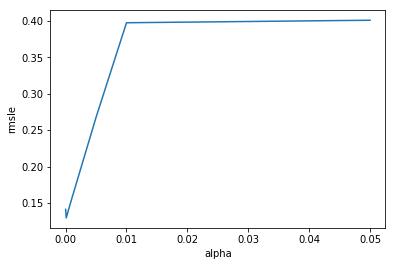

In [20]:
# **** Soodong used numerical columns only, none numerical column brings error.
# We need to fix and convert together.

N_FOLDS = 10

def rmsle_cv(model, x, test_labels):
    # KFold is for cross-validation
    kf = KFold(N_FOLDS, shuffle=True, random_state=0).get_n_splits(x)
    rsle = np.sqrt(-cross_val_score(model, x, test_labels, scoring="neg_mean_squared_error", cv=kf))
    return rsle.mean()

def lasso_fn(alphas):
    # rmsle == Root Mean Squared Logarithmic Error
    def rmsle(y, y_prediction):
        # https://stackoverflow.com/questions/17197492/root-mean-square-error-in-python
        return np.sqrt(mean_squared_error(y, y_prediction))

    rmsle_list = []
    for i in alphas:
        lasso_reg = Lasso(alpha=i, normalize=True)
        rmsle_list.append(rmsle_cv(lasso_reg, x_numerical_feature_scaled, y))

    plt.plot(alphas, rmsle_list)
    plt.xlabel("alpha")
    plt.ylabel("rmsle")
    plt.tick_params("L1 Lasso Model")

    print("The smallest rmsle by Lasso model is {:.4f}".format(min(rmsle_list)))
    print("This occurs when alpha is {}".format(alphas[np.argmin(rmsle_list)]))

    return alphas[np.argmin(rmsle_list)]

ALPHAS = [0.00001, 0.0001, 0.001, 0.005, 0.01, 0.05]
min_alpha_Lasso = lasso_fn(ALPHAS)

In [ ]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, ElasticNet, ElasticNetCV

In [ ]:
numerics = list(train.select_dtypes(include=np.number).columns)
print(numerics)
categorical = list(train.select_dtypes(exclude=np.number).columns)
print(categorical)



In [ ]:
from collections import defaultdict
from sklearn.metrics import mean_squared_error
import time
res = defaultdict(dict)
def benchmark(model, name=None):
    if not name:
        name = model.__class__.__name__
    t0 = time.clock()
    model.fit(X_train_data, y_train_data_log)
    res[name]['train_time'] = time.clock() - t0
    t0 = time.clock()
    pred = model.predict(X_dev_data)
    res[name]['test_time'] = time.clock() - t0
    res[name]['rmse'] = np.sqrt(mean_squared_error(y_dev_data_log, pred))
    return model

In [ ]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
benchmark(LinearRegression())
benchmark(Ridge(alpha=5.2))
benchmark(ElasticNet(alpha=0.01))
est = benchmark(GradientBoostingRegressor(learning_rate=0.1, n_estimators=200))
benchmark(RandomForestRegressor(n_estimators=30, max_depth=10))
res_df = pd.DataFrame(data=res).T
res_df[['train_time', 'test_time', 'rmse']]

In [ ]:
FIGSIZE = (11,7)
type(est.feature_importances_)
fx_imp = pd.Series(est.feature_importances_, index=features)
fx_imp /= fx_imp.max()  # normalize
#fx_imp.sort()
fx_imp.nlargest(20).plot(kind='barh', figsize=FIGSIZE)

## Partial dependence

  * Relationship between the response and a set of features, marginalizing over all other features
  * Intuitively: expected response as a function of the features we conditioned on

In [ ]:
from sklearn.ensemble.partial_dependence import plot_partial_dependence
features = ['MasVnrArea', 'MoSold', 'MiscVal', 'FullBath', 'SaleCondition_Family','OpenPorchSF', '2ndFlrSF', 'EnclosedPorch',
           'WoodDeckSF','TotalBsmtSF_Log']
fig, axs = plot_partial_dependence(est, X_train_data, features, feature_names=features, 
                                   n_cols=6, figsize=(20,15))

## Summary & Key Results

In this section, we will present our key findings in terms of key predictor variables and their parameter values. We will also summary the modeling process and learning from it.

## References

In [ ]:
# Legacy does, do not use yet.

numerical_features = train.select_dtypes(exclude = ['object']).columns
categorical_features = train.select_dtypes(include = ["object"]).columns

# find discrete features within numerical features
discrete_features = []
print("Discrete numerical features:")
for var in numerical_features:
    if len(train[var].unique())<20:
        print(var, ' values: ', train[var].unique())
        discrete_features.append(var)
        
print('**There are {} categorical variables; {} discrete variables out of {} total numeric vars**'.format(len(discrete_features), len(discrete_features), len(numerical_features)))

numerical_features, categorical_features

import seaborn as sns
num_melt = pd.melt(train, id_vars=['SalePrice'], 
                   value_vars = [f for f in numerical_features if f not in ['Id', 'SalePrice']])
g = sns.FacetGrid(data=num_melt, col="variable", col_wrap=4, sharex=False, sharey=False)
g.map(sns.distplot, "value")

X_all = train.drop([f for f in categorical_features] + log_features + ['SalePrice'], axis=1)
X_test = test.drop([f for f in categorical_features] + log_features , axis=1)


X_all_categorical = pd.get_dummies(train[categorical_features],drop_first=True)
X_test_categorical = pd.get_dummies(test[categorical_features],drop_first=True)

print("{}, {}".format(X_all_categorical.shape,X_test_categorical.shape))



std = StandardScaler()
X_all[:] = std.fit_transform(X_all)
X_test[:] = std.fit_transform(X_test)

y_all = train.SalePrice
#y_all[:] = np.log1p(y_all)


# TODO: Perform ordinal encoding of categorical_features
all_features_train = [X_all, X_all_categorical]
X_all = pd.concat(all_features_train, axis=1)
all_features_test = [X_test, X_test_categorical]
X_test = pd.concat(all_features_test, axis=1)



# split 80/20 train-dev
X_train_data, X_dev_data, y_train_data, y_dev_data = train_test_split(X_all,
                                                    y_all,
                                                    test_size=0.3,
                                                    random_state=1)
features = list(X_train_data)

y_train_data_log = np.log(y_train_data)
y_dev_data_log = np.log(y_dev_data)
#y_all.shape, X_all.shape, X_test.shape
#print(y_dev_data)
X_train_data.shape, X_dev_data.shape